In [228]:
#!pip install ipdb
# import ipdb; ipdb.set_trace() # debugging starts here

# One-liner to start the debugger here.
#    from IPython.core.debugger import Tracer; Tracer()() 

In [584]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from numpy.linalg import inv

In [585]:
class MotorDc(object):
    # Propiedades del sistema
    J = 0.0167;
    b = 0.0167;
    Kb = 0.8;
    Kt = 0.8;
    R = 0.6;
    L = 0.012;
    T = 0.01;

    def __init__ (self,x0):
        # Estado Systema
        self.xk= x0 #np.array( [ [.5],[.3]]);
        self.x_k1= np.zeros_like(self.xk)
        self.f = np.zeros_like(self.xk)
        self.g = np.zeros_like(self.xk)
        
    
    def Sistema(obj,u):
        Gamma = 0

        Minterf = np.array([ [-obj.b / obj.J,  obj.Kt / obj.J],
                            [-obj.Kb / obj.L,  -obj.R / obj.L]] )
        
        obj.f = obj.xk + obj.T * Minterf @ obj.xk
        
        Minterg = np.array([[0], [1 / obj.L]])
        obj.g = obj.T*Minterg;
        
        obj.x_k1 = obj.f + obj.g* u + Gamma;
        obj.xk = obj.x_k1
        return obj.x_k1


In [586]:
class Control_Op(MotorDc):
    
    def __init__(self,x0,P):
        super(Control_Op,self).__init__(x0)
        self.P = P

    
    def Control(obj,Ref ):
        # Control optimo inverso
        hi=obj.g.T@obj.P@(obj.f-Ref);
        Ji=1/2*obj.g.T@obj.P@obj.g;        
        I=-np.eye(*Ji.shape );           
        u=-1/2*inv(I +Ji)@hi;
        return u
        #u=-pinv(2 +Ji)*hi;


In [610]:
class System(object):
    
    def __init__(self,N,x0,P ):
        self.x=np.empty( (2,N), dtype=float)
        self.x[:,[0] ] = x0
        self.P=P
        self.c = Control_Op(x0,P)
        
    def simular(self,k,ref):
        #ref = np.array([[0],[0] ])
        self.x[:,[k] ] = self.c.Sistema(self.c.Control(ref ))
        
    def grafica(self,t):
        plt.plot(t,self.x.T);

## Referencia

In [611]:
#Ref
fin = 5
T = 0.1
t = np.arange(0,fin,T)
ref1 = np.sin(np.arange(0,fin,T)*4)
#plt.plot(t,ref1)
#Ref
ref2 = np.zeros_like(ref1)
ref = np.stack( [ref1,ref2] )

# Ganancia P aleatoria

In [612]:
mu, sigma = 0, 0.1 # mean and standard deviation
a1=np.random.normal(mu,sigma)
a2=np.random.normal(1,.5)
a3=np.random.normal(1,.5)
a4=np.random.normal(10,2)

2.82571285467


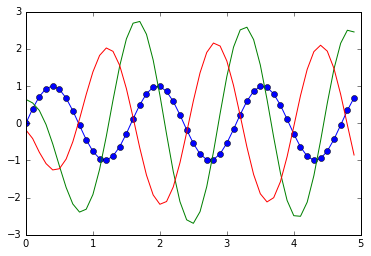

In [639]:
T = .01
N=50


mu, sigma = 10, 5 # mean and standard deviation
a1=np.random.normal(mu,sigma)
a2=np.random.normal(1,.5)
a3=np.random.normal(1,.5)
a4=1 #np.random.normal(10,2)

P = np.array([ [a1,a2],[a2,a3]])*a4 #np.array([ [10,0.5],[0.5,.06]])
x0 = np.array( [ [.5],[.3]])

s1 = System(N,x0,P)

#for k,inf in range(1,N):
for k,inf in enumerate(ref[0,:]):
    s1.simular(k,ref[:,[k]])

plt.plot(t,ref[0,:].T,'o-')
s1.grafica(t)
print (np.sum( (s1.x[0,:]-ref[0,:])**2)/len(s1.x[0,:]) )

# Utilizando PSO

In [644]:
from pyswarm import pso

In [751]:
def OPInv(p):
    a1=p[0]
    a2=p[1]
    a3=p[2]
    a4=1 #np.random.normal(10,2)

    P = np.array([ [a1,a2],[a2,a3]])*a4 #np.array([ [10,0.5],[0.5,.06]])
    x0 = np.array( [ [.5],[.3]])

    s1 = System(N,x0,P)

    for k,inf in enumerate(ref[0,:]):
        s1.simular(k,ref[:,[k]])

    return (np.sum( (s1.x[0,:]-ref[0,:])**2)/len(s1.x[0,:]) )

def con(x):
    a1 = x[0]
    a2 = x[1]
    a3 = x[2]
    P = np.array([ [a1,a2],[a2,a3]])
    w,_=np.linalg.eig(P)     
    return w>0

In [752]:
# Define the lower and upper bounds for H, d, t, respectively
lb = [0, 0.001,0.001]
ub = [100000, 1,1]

xopt, fopt = pso(OPInv,lb,ub,swarmsize=1000,f_ieqcons=con)

Stopping search: maximum iterations reached --> 100


In [753]:
xopt

array([  5.29509237e+04,   1.00000000e-03,   1.00000000e-03])

ValueError: x and y must have same first dimension

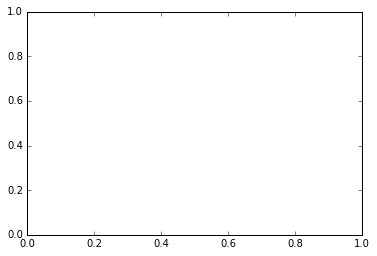

In [755]:
a1 = xopt[0]
a2 = xopt[1]
a3 = xopt[2]
a4=1 #np.random.normal(10,2)

P = np.array([ [a1,a2],[a2,a3]])*a4 #np.array([ [10,0.5],[0.5,.06]])
x0 = np.array( [ [.5],[.3]])

s1 = System(N,x0,P)

for k,inf in enumerate(ref[0,:]):
    s1.simular(k,ref[:,[k]])
    
plt.plot(t,ref[0,:].T,'o-')
s1.grafica(t)
print (np.sum( (s1.x[0,:]-ref[0,:])**2)/len(s1.x[0,:]) )

In [756]:
w,_=np.linalg.eig(P)     
w,w>0

(array([  5.29509237e+04,   9.99999981e-04]),
 array([ True,  True], dtype=bool))

In [747]:
import IPython.display as ipd
#ipd.Audio('audio/conga_groove.wav')

In [749]:
sr = 22050 # sample rate
T = 2.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*440*t)                # pure sine wave at 440 Hz

In [750]:
ipd.Audio(x, rate=sr) # load a NumPy array